In [2]:
import os

# Some global configuration variables
ROOT_PATH = 'datasets/'
DATASET_NAME = 'Nottingham/'
FOLDERS = ['train/', 'valid/', 'test/']

def get_folder_path(folder_num):
    return ROOT_PATH + DATASET_NAME + FOLDERS[folder_num]

def get_files_in_folder(folder_path):
    _, _, files = next(os.walk(folder_path))
    return files

param = {
    'input_size': 75,
    'hidden_time_size': 200,
    'hidden_note_size': 100,
    'dropout': 0.5,
    'batch_size': 16, # these are small because the matrices need to fit in my memory
    'max_time': 50,
    
    # Constants actually
    'octave_range': 12, # the number of semitones in an octave (also nr of notes in an octave)
    'piano_note_nr': 88, # number of notes a piano can play
    'context_size': 50, # 2 * octave_range + 2 -> size of the context from the last timestep
}

## Dataset

The data is in MIDI format. We used the library music21 to read it as a score,
which then we transformed to piano rolls representation (timestep x note x 2) and then
transformed it again into a tensor of dimensions (timestep x note x input_size).

The input_size dimension contains a vector with the following components:
[ note, pitchclass, vicinity, context ]
where note is a scalar representing what key/note is this, pitchclass is a
one-hot vector reprezenting the pitchclass of the note (C, D, E, ..., B), vicinity
represents what notes were played in the last timestep within one octave up and
down of the current note and wether they were accentuated and finally context
tells us how many notes of the same pitchclass were played in the last timestep,
for all pitchclasses.

So, the dimensions are: note = 1x1, pitchclass = 1x12 (12 notes in an octave,
including accidentals), vicinity = 1x50 (incldes the note), context = 1x12
and they add up to 1x75.

This is based on this blog post: http://www.hexahedria.com/2015/08/03/composing-music-with-recurrent-neural-networks/ and on the papers 'Generating Music using an LSTM Network' by Nikki Kotecha & Paul Young and 'Generating Polyphonic Music Using Tied
Parallel Networks' by Daniel D. Johnson.

In those sources, the input dimension also contains a 1x4 vector that encodes the
position of the note in the measure. However, in the blog it says that the author
assumes a 4/4 time signature. Also (probably) he samples the midi at intervals
of 1/8 (șaisprezecimi). In my case, I chose to sample each piece at a different interval
according to the smallest note duration found within the piece. In this way, the network
will see all the notes played at the right time. Also we ignore all the information
related to key, tempo and measures. Because of the last thing, and the fact that
we don't exclude pieces that are not in 4/4, we can't generate the extra vector. Hopefully the network can learn measure structure solely based on the temporal LSTM.

In [2]:
import music21 as M
import torch

def keys_from(pitches):
    '''
    The first key on the standard, 88-key piano is A (octave 0),
    and the top note is C (octave 8).
    music32 pitchClasses go from 0 (note C) to 11 (note B) and
    the octave is a separated attribute,
    so the formula for translating to piano indices is:
    piano_idx = 12 * (pitch_octave - 1) + pitch_class + 3
    Some visual help with the formula:
    https://en.wikipedia.org/wiki/Piano_key_frequencies#/media/File:Piano_Frequencies.svg
    '''
    note_nr = param['piano_note_nr']
    octave_range = param['octave_range']
    for p in pitches:
        if p.octave is None: # just to make sure
            p.octave = M.defaults.pitchOctave
    return [ octave_range * (p.octave - 1) + p.pitchClass + 3 for p in pitches ]

def get_pitchclass(key):
    return (key - 3) % param['octave_range']

def pitches_from(keys):
    # Input: a list of piano keys (indices)
    note_nr = param['piano_note_nr']
    octave_range = param['octave_range']
    return [M.pitch.Pitch(pitchClass = (k-3) % octave_range,
                          octave = (k-3) // octave_range + 1)
            for k in keys]

def find_smallest_duration(flatscore):
    min = 500.0 # flatscore[0].duration.quarterLength
    for i in flatscore:
        if min >= i.duration.quarterLength and i.duration.quarterLength != 0.0:
            min = i.duration.quarterLength
    return min

def transform_chord(chord, time_increment):
    timesteps = int(chord.duration.quarterLength / time_increment)
    ret = torch.zeros(timesteps, param['piano_note_nr'], 2)
    keys = keys_from(chord.pitches)
    ret[:, keys, 0] = 1.0
    ret[0, keys, 1] = 1.0
    return ret

def combine_parts(original_part, new_part, t):
    '''
    Input: roll is a tensor of size timesteps x note_nr x 2
           new_part is a tensor of size steps x note_nr x 2
           t is an integer
    Output: a tensor of size timesteps x note_nr x 2
            obtained from roll where at the position t we also press
            the keys from new_part
    '''
    steps = len(new_part)
    tmp = torch.stack((original_part[t:t+steps, :, :], new_part))
    tmp, _ = torch.max(tmp, dim = 0)
    original_part[t:t+steps, :, :] = tmp
    return original_part

def get_pianoroll(flatscore):
    '''
    Input: a music21 score that has been flattened and contains only
      notes and chords and rests.
    Output: a torch.tensor of dimensions  timesteps x note_nr x 2
      out[t][note][0] is 1 if the note is playing at time t and 0 if it is not
      out[t][note][1] is 1 if the key is articulated at time t and 0 if it is just playing
    
    This should be improved to take into account ornament notes.
    '''
    note_nr = param['piano_note_nr']
    # One timestep corresponds to an interval of the smallest duration in the
    # score. This way we don't miss anything important in the score and also
    # we keep the timesteps number at a minimum
    time_increment = find_smallest_duration(flatscore)
    timesteps = int(flatscore.duration.quarterLength / time_increment)
    roll = torch.zeros(timesteps, note_nr, 2)
    for el in flatscore:
        if el.duration.quarterLength == 0.0:
            # apparently this is a problem
            continue
        if type(el) is M.note.Rest:
            continue
        if type(el) is M.note.Note:
            chord = M.chord.Chord([el])
        else:
            chord = el
        part = transform_chord(chord, time_increment)
        t = int(el.getOffsetBySite(flatscore) / time_increment)
        roll = combine_parts(roll, part, t)
    return roll

def get_slice_indices(note):
    octave = param['octave_range']
    note_nr = param['piano_note_nr']
    roll_low = max(0, note - octave)
    roll_high = min(note_nr, note + octave + 1)
    # since context_size is 50, we have two centers: 24 and 25
    context_center = param['context_size'] // 2
    out_low = 0
    out_high = param['context_size']
    if note < octave:
        out_low = context_center - 2 * note - 1
    if note >= note_nr - octave:
        out_high = context_center + 2 * (note_nr - note - 1) + 1
    offset = octave + 1
    return out_low + offset, out_high + offset, roll_low, roll_high

def get_all_pitchclasses(pianoroll):
    octave_range = param['octave_range']
    timesteps = pianoroll.shape[0]
    # take care of the whole octaves (from C to C) that fit inside the piano
    tmp = pianoroll[:, 3:-1, 0].view(timesteps, -1, octave_range)
    tmp = torch.sum(tmp, dim = 1)
    # and don't forget the notes left behind
    tmp[:, 9:12] += pianoroll[:, 0:3, 0] # 9:12 because the leftmost key is an A
    tmp[:, 0] += pianoroll[:, -1, 0] # 0 because the rightmost key is a C
    return tmp[:-1,:]

def pianoroll_to_input(pianoroll):
    # pianoroll: timesteps x note_nr x 2
    timesteps = pianoroll.shape[0]
    note_nr = pianoroll.shape[1]
    pitch_nr = param['octave_range']
    input_size = param['input_size']
    pitch = get_all_pitchclasses(pianoroll)
    out = torch.zeros(timesteps, note_nr, input_size)
    for n in range(note_nr):
        # the first part of the input vector is just the note played
        # to let the network know about it's pitch height (size 1)
        out[:, n, 0] = n / note_nr # scale it to [0, 1]
        # the second part is a one-hot encode vector for the pitch class (size 12)
        pitchclass = get_pitchclass(n)
        out[:, n, pitchclass + 1] = 1
        # the third part is the notes played in the last timestep (size 50)
        olow, ohigh, plow, phigh = get_slice_indices(n)
        out[1:, n, olow:ohigh] = pianoroll[:-1,plow:phigh,:].view(-1, (phigh - plow) * 2)
        # the fourth part shows how many notes of the same pitchclass
        # were played in the last timestep, relative to n
        shift = torch.zeros(pitch.shape)
        shift[:, :pitch_nr - pitchclass] = pitch[:, pitchclass:]
        shift[:, pitch_nr - pitchclass:] = pitch[:, :pitchclass]
        out[1:, n, 63:] = shift # they are the same for all notes
    return out

def process_midi_file(filename):
    # first transform the file into a score
    score = M.converter.parse(filename)
    # flatten everything and retain only the notes/chords and rests
    score = score.flat.getElementsByClass(('Note', 'Chord', 'Rest'))
    # transform the score into a piano roll
    roll = get_pianoroll(score)
    # and finally get the input for our network
    score = pianoroll_to_input(roll)
    return score, roll # keep the roll around to extract labels from it

## More data processing

With the help of the process_file() function we can now move on to define
Dataset(s) and DataLoader(s) that we will use to train/evaluate/test our model.

In [3]:
from torch.utils.data import Dataset, DataLoader

class MusicDataset(Dataset):
    def __init__(self, folder_path, max_time = 24, load_fn = process_midi_file):
        self.timelen = max_time
        self.folder_path = folder_path
        self.files = get_files_in_folder(folder_path)
        self.load_fn = load_fn
    
    def __len__(self):
        # this could decrease if we find a bad file
        return len(self.files)
    
    def __getitem__(self, index):
        if index >= len(self.files):
            # just improvise
            index = torch.randint(len(self.files), [1]).item()
        sample, roll = self.load_fn(self.folder_path + self.files[index])
        while len(sample) < self.timelen+1:
            self.files.pop(index)
            # choose a random index instead
            index = torch.randint(len(self.files), [1]).item()
            sample, roll = self.load_fn(self.folder_path + self.files[index])
        wiggle_room = len(sample) - self.timelen - 1
        if wiggle_room != 0:
            rnd = torch.randint(wiggle_room, [1]).item()
        else:
            rnd = 0
        return sample[rnd:rnd+self.timelen], roll[rnd+1:rnd+self.timelen+1]

In [4]:
# Load the data into memory
def pickelize(filename):
    # This was used to transform everything into a pickle
    # for more time efficiency
    batch, roll = process_midi_file(filename)
    filename = filename + '.pickle'
    print('Saved file {}'.format(filename))
    torch.save((batch, roll), filename)
    return batch, roll

def load_pickle(filename):
    batch, roll = torch.load(filename)
    return batch, roll

def pickelize_everything():
    # converts everything in the dataset into a pickle
    # after running this, you should go to the dataset folders
    # and move the .pickle files into a pickle/ subfolder
    for i in range(3):
        D = MusicDataset(get_folder_path(i), max_time = param['max_time'],
                   load_fn = pickelize)
        L = DataLoader(D, batch_size = param['batch_size'], shuffle = True,
            num_workers = 4, pin_memory = False)
        for file in L:
            pass

dataset = MusicDataset(get_folder_path(2) + 'pickle/', max_time = param['max_time'],
                      load_fn = load_pickle)
DL = DataLoader(dataset, batch_size = 8, shuffle = True, num_workers = 4)
for i, data in enumerate(DL):
    print(i, data[0].shape)

In [5]:
from torch.nn import LSTM, Linear, Softmax, Module

class BALSTM(Module):
    def __init__(self, input_size, t_hidden, n_hidden, dropout):
        super().__init__()
        self.t_layer = LSTM(input_size = input_size, hidden_size = t_hidden, num_layers = 2,
                               batch_first = True, dropout = dropout)
        # the second LSTM layer gets as input the output of the first LSTM
        self.n_layer = LSTM(input_size = t_hidden, hidden_size = n_hidden, num_layers = 2,
                              batch_first = True, dropout = dropout)
        
        self.o_layer = Linear(n_hidden, 4)
        self.softmax = Softmax(dim = -1) # transform the note dimension into a probability distribution
    
    # this also returns the hidden states of x (on the temporal dimension)
    def predict(self, x, hidden_states = None):
        if hidden_states is None:
            hidden_states = [None for i in range(x.shape[2])]
        shape = x.shape
        x = [self.t_layer(x[:,:,n,:], hidden_states[n]) for n in range(x.shape[2])]
        hidden_states = [ el[1] for el in x ]
        x = torch.stack([ el[0] for el in x ], dim = 2)
        # now the note layer
        x = torch.stack([self.n_layer(x[:,t,:,:])[0] for t in range(x.shape[1])], dim = 1)
        x = self.o_layer(x)
        shape = (shape[0], shape[1], shape[2], 2, 2)
        x = x.view(shape) # the output shape just has an extra dimension at the end
        return self.softmax(x), hidden_states
    
    def forward(self, x):
        # the output must have batch x time x note x 2 x 2 shape
        # x has dimensions batch x time x note x input_size
        # First thing, we run only the time layers for all the notes
        shape = x.shape # save initial dimensions for later use
        x = torch.stack([self.t_layer(x[:,:,n,:])[0] for n in range(x.shape[2])], dim = 2)
        # now calculate the note step
        x = torch.stack([self.n_layer(x[:,t,:,:])[0] for t in range(x.shape[1])], dim = 1)
        # and now pass through the final layer and we're good
        x = self.o_layer(x)
        shape = (shape[0], shape[1], shape[2], 2, 2)
        x = x.view(shape)
        return self.softmax(x)

In [6]:
import torch.nn.functional as F
from torch.optim import Adadelta
# The loss function.
def calculate_loss(logits, targets):
    # logits: batch x time x note x 2 x 2
    # targets: batch x time x note x 2
    # For the nll loss, we need an extra dimension
    return F.nll_loss(logits.permute(0, 4, 1, 2, 3),
                      targets.to(device = 'cuda', dtype = torch.long))

model = BALSTM(param['input_size'], param['hidden_time_size'], param['hidden_note_size'], param['dropout'])
model.cuda()
optimizer = Adadelta(model.parameters())

# Testing that everything is ok.
pred = model(sample.cuda())
print('Prediction made, calculating loss.')
loss = calculate_loss(pred, labels.to(dtype=torch.long))
print('loss = ', loss, ', now backpropagating.')
loss.backward()
print('Gradients computed.')
optimizer.step()
print('Optimization step done.')

In [7]:
import heapq

class Backup:
    '''
    Keep on the disk only the best_n items.
    
    The files will be found in the savedir directory.
    '''
    def __init__(self, savedir, best_n, stem = 'backup'):
        if best_n <= 0:
            raise IndexError('best_n must be positive')
        self.savedir = savedir
        self.max_nr = best_n
        self.scores = [] # min-heap with (score, index) elements
        self.object_names = [] # all the filenames of the objects stored
        self.stem = stem
        self.unique = 0 # index used to make sure all files are unique
    
    def save(self, item, score, serial = 0):
        '''
        item - the object that is considered for backup
        score - it's score; the higher the better
        serial - some number you wish to append to the filename
        
        The filename will be of the form
        stem-unique-score-serial
        '''
        if len(self.object_names) < self.max_nr:
            name = '{}-{}-{}-{}'.format(self.stem, self.unique, score, serial)
            #name = self.stem + str(self.unique) + str(score) + serial
            self.object_names.append(name)
            idx = len(self.object_names) - 1
            heapq.heappush(self.scores, (score, idx))
            torch.save(item, self.savedir + name)
            self.unique += 1
        else: # decide if the item is good enough
            worst = self.scores[0]
            if score <= worst[0]:
                return # not worth it
            idx = worst[1]
            os.remove(self.savedir + self.object_names[idx])
            name = '{}-{}-{}-{}'.format(self.stem, self.unique, score, serial)
            self.object_names[idx] = name
            heapq.heapreplace(self.scores, (score, idx))
            torch.save(item, self.savedir + self.object_names[idx])
            self.unique += 1

In [8]:
def get_data_loaders(data):
    data_loaders = []
    for d in data:
        if type(d) is DataLoader:
            data_loaders.append(d)
            continue
        # else it must be a string to the root folder of the data
        if os.path.exists(d + 'pickle/'):
            # choose this one to speed up things
            d = d + 'pickle/'
            load_fn = load_pickle
        else:
            load_fn = process_midi_file
        tmp = MusicDataset(d, param['max_time'], load_fn)
        tmp = DataLoader(tmp, batch_size = param['batch_size'], shuffle = True,
                num_workers = 4, pin_memory = False)
        data_loaders.append(tmp)
    return data_loaders

def get_loss_on_data(data, model):
    model.eval()
    batch_losses = []
    with torch.no_grad():
        for batch, label in data:
            batch = model(batch.cuda())
            loss = calculate_loss(batch, label)
            batch_losses.append(loss)
    batch_losses = torch.tensor(batch_losses)
    return torch.mean(batch_losses).item(), batch_losses

def train_model(data, model, optimizer, epochs, savedir = 'saved_models/', best_n = 5):
    '''
    data - be a tuple with the train data(loader), validation data, and test data.
    model - the network to be trained
    optimizer - the optimizer used
    epochs - how many iterations over the train data should we do
    savedir - where should we save the model's parameters
    best_n - how many model parameters should we keep around on disk
    '''
    tr_data, vl_data, te_data = get_data_loaders(data)
    # keep on disk the models with the lowest loss on validation
    backup = Backup(savedir, best_n, 'model')
    tr_loss = [] # loss per batch on train data
    vl_loss = [] # loss per epoch on validation data
    # batch_loss = [] # loss per optimization step
    for ep in range(1, epochs+1):
        model.train()
        for batch, label in tr_data:
            optimizer.zero_grad()
            # get the model's prediction
            batch = model(batch.cuda())
            loss = calculate_loss(batch, label)
            loss.backward()
            optimizer.step()
            # save the batch_loss
            tr_loss.append(loss.detach_().item())
        vl_loss.append(get_loss_on_data(vl_data, model)[0])
        #te_loss.append(get_loss_on_data(te_data, model)[0])
        print('Epoch {} done: tr_loss = {}  vl_loss = {}'.format(
                ep, tr_loss[-1], vl_loss[-1]))
        # for saving the model we use validation loss as score
        # negative because lower score is better (instead of higher like backup wants)
        backup.save(model.state_dict(), -vl_loss[-1], ep)
        if (ep) % 1 == 0:
            # also save the metrics just in case i feel like interrupting the kernel
            torch.save((tr_loss, vl_loss), 'latest-metrics.pickle')
    return tr_loss, vl_loss

Epoch 1 done: tr_loss = -0.9611989259719849  vl_loss = -0.9636088013648987
Epoch 2 done: tr_loss = -0.9655693769454956  vl_loss = -0.96738600730896
Epoch 3 done: tr_loss = -0.9701767563819885  vl_loss = -0.9686729907989502
Epoch 4 done: tr_loss = -0.9707927703857422  vl_loss = -0.9695128798484802
Epoch 5 done: tr_loss = -0.9676297903060913  vl_loss = -0.9699755311012268


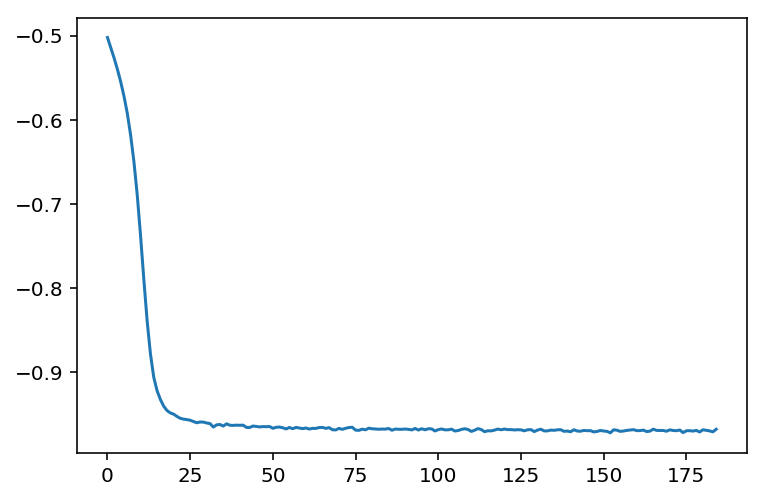

In [9]:
datafolders = (get_folder_path(0), get_folder_path(1), get_folder_path(2))
metrics = train_model(datafolders, model, optimizer, 5)

import matplotlib.pyplot as plt

plt.plot(metrics[0])
plt.show()

## Generating music

To generate new pieces, we run the model sequentially (with respect to the
time dimension) at each step feeding it as input the notes that were generated
in the previous step and saving the outputs from all the timesteps.

These outputs are in a pianoroll format, exactly like the format returned by
the get_pianoroll() function. To actually hear the music, we will convert it
to MIDI via the music21 library.

In [10]:
def get_stream(pianoroll, time_increment = 0.25):
    '''
    pianoroll - has dimensions time x note_nr x 2
    time_increment - denotes how much time passes when we take a step
        in the time dimension; this will also be the smallest duration a
        note can have. The unit is in music21 quarterLengths, which means
        that a value of 1.0 denoes a quarter note.
    
    Returns a music21 stream encoding for the pianoroll.
    
    This function is supposed the inverse of get_pianoroll(), 
    in the sense that given the same time_increment, and x, y such as:
    x -> get_pianoroll() -> get_stream() -> y,
    then playing x is the same as playing y. In practice this is not the
    case because the transformation to pianorolls discards all information
    regarding nuances, instruments and ornaments. On the Nottingham dataset
    however this is a perfect inverse since it doesn't contain such things.
    
    The actual streams x and y will be different because this method
    of getting a stream is really simplistic and doesn't produce any
    chords (for example). And anyway, the MIDI representation of a
    piece of music is not unique.
    '''
    notes = []
    durations = []
    offsets = []
    for n in range(pianoroll.shape[1]):
        # basically for each note on the piano
        # we loop through the all timesteps and
        # for all the sequences of (1, 0)'s we emit
        # music21 note with duration = time_increment * length_of_the_sequence
        last_played = False
        start_t = 0 # updated when a new note starts playing
        for t in range(0, pianoroll.shape[0]):
            step = pianoroll[t][n]
            if last_played:
                if step[0] == 1.0 and step[1] == 0.0:
                    continue # we just sustain the current note one more timestep
                # if we are here, it means that the current note has to end
                notes.append(n)
                durations.append(((t - start_t) * time_increment))
                offsets.append((start_t * time_increment))
                # and now see if we need to play a new note or not
                if step[0] == 1.0: # this means the note is articulated
                    start_t = t
                else: # no note is played
                    last_played = False
            else:
                if step[1] == 1.0: # in this case the articulation doesn't matter
                    start_t = t
                    last_played = True
                # else nothing else matters
        if last_played: # we have to finish off the last note
            notes.append(n)
            durations.append(((pianoroll.shape[0] - start_t + 1) * time_increment))
            offsets.append((start_t * time_increment))
    # now you might have noticed that in notes we don't put actual
    # music21 Notes or Pitches, but the key that was pressed. Fortunally, we
    # have the function pitches_from() that just solves that.
    notes = [M.note.Note(n) for n in pitches_from(notes)]
    # and now just set the offsets and durations
    for n, dur, off in zip(notes, durations, offsets):
        n.duration.quarterLength = dur
        n.offset = off
    # and with all this done, order them by the offset and put them in a music21 stream
    notes.sort(key = lambda n : n.offset)
    stream = M.stream.Stream()
    for idx, note in enumerate(notes):
        stream.insert(note)
    #stream.insert(notes)
    piano = M.instrument.Piano()
    stream.insert(piano)
    return stream

#### testing the get_stream function:
score = M.converter.parse('test.mid') # get the original score
flatscore = score.flat.getElementsByClass(('Note', 'Chord', 'Rest'))
pianoroll = get_pianoroll(flatscore) # put it in pianoroll format
time_increment = find_smallest_duration(flatscore)
stream = get_stream(pianoroll, time_increment) # and put it back into stream form
#### now stream and score should sound mostly the same.
stream.write(fp = 'roundtrip.mid', fmt = 'midi') # and back to MIDI

In [14]:
def sample_from(prob):
    # prob: 1 x note_nr x 2 x 2
    prob.squeeze_(0) # get rid of the useless 1
    # sample (note_nr x 2) uniforms in the range [0,1]
    # the probability that unif[n][0] < prob[n][0][1]
    # is exactly prob[n][0][1] because unif is a uniform,
    # so in other words by checking this we sampe from
    # a Bernoulli of parameter prob[n][0][1].
    # Simmilarly for unif[n][1] < prob[n][1][1].
    unif = torch.rand(prob.shape[0], 2, device = "cuda")
    unif = unif < prob[:, :, 1]
    return unif.to(dtype = torch.float32)

def compose(model, length):
    '''
    Create a pianoroll with original music. (unless we overfitted)
    output size: length x note_nr x 2
    '''
    model.eval()
    note_nr = param['piano_note_nr']
    # +1 because pianoroll_to_input cannot work with 1 x note_nr x 2 rolls
    roll = torch.zeros(length+1, note_nr, 2)
    # initialize the first timestep with something random but nonzero
    roll[0, :, 0] = torch.randint(0, 2, (note_nr,), dtype = torch.float32)
    roll[0, :, 1] = roll[0, :, 0]
    hidden_states = None
    for t in range(1, length+1):
        last_output = roll[t-1:t+1, :, :]
        # batch has the size 2 x note_nr x input_size, but we
        # only use batch[1]
        batch = pianoroll_to_input(last_output)
        batch = batch[1].view(1, 1, batch.shape[1], batch.shape[2])
        prob, hidden_states = model.predict(batch.cuda(), hidden_states)
        next_output = sample_from(prob)
        roll[t] = next_output
    return roll[1:] # get rid of that +1

In [20]:
#state_params = torch.load('saved_models/best_so_far')
#model.load_state_dict(state_params)

piece = compose(model, 300)
piece = get_stream(piece, time_increment = 0.5)
piece.write(fp = 'composed.mid', fmt = 'midi')

'composed.mid'